<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#BM25-(Best-Match)-vs.-TFIDF" data-toc-modified-id="BM25-(Best-Match)-vs.-TFIDF-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>BM25 (Best Match) vs. TFIDF</a></span></li><li><span><a href="#Generating-some-text" data-toc-modified-id="Generating-some-text-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generating some text</a></span></li><li><span><a href="#BM25---Implementation" data-toc-modified-id="BM25---Implementation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>BM25 - Implementation</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#References" data-toc-modified-id="References-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>References</a></span></li><li><span><a href="#Requirements" data-toc-modified-id="Requirements-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Requirements</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-warning">
<font color=black>

**What?** BM25 - an alternative to TFITF

</font>
</div>

# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import math
import json
import requests

# BM25 (Best Match) vs. TFIDF
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-info">
<font color=black>

- **Both** BM25 and TFIDF try to represent our text in a vector space.
- **TFIDF**: If the term is common in this article, but relatively rare elsewhere, then the TFIDF score will be high, and documents that have higher TFIDF score would be considered as very relevant to the search term.
- **BM25** improves upon TFIDF by casting relevance as a probability problem. A relevance score, according to probabilistic information retrieval, ought to reflect the probability a user will consider the result relevant.
- The graph below show how the two methods diverge as the frequency increases.

</font>
</div>

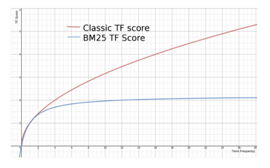

# Generating some text
<hr style = "border:2px solid black" ></hr>

In [3]:
# we'll generate some fake texts to experiment with
corpus = [
    'Human machine interface for lab abc computer applications',
    'A survey of user opinion of computer system response time',
    'The EPS user interface management system',
    'System and human system engineering testing of EPS',
    'Relation of user perceived response time to error measurement',
    'The generation of random binary unordered trees',
    'The intersection graph of paths in trees',
    'Graph minors IV Widths of trees and well quasi ordering',
    'Graph minors A survey'
]

# remove stop words and tokenize them (we probably want to do some more
# preprocessing with our text in a real world setting, but we'll keep
# it simple here)
stopwords = set(['for', 'a', 'of', 'the', 'and', 'to', 'in'])
texts = [
    [word for word in document.lower().split() if word not in stopwords]
    for document in corpus
]

# build a word count dictionary so we can remove words that appear only once
word_count_dict = {}
for text in texts:
    for token in text:
        word_count = word_count_dict.get(token, 0) + 1
        word_count_dict[token] = word_count

texts = [[token for token in text if word_count_dict[token] > 1] for text in texts]
texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

# BM25 - Implementation
<hr style = "border:2px solid black" ></hr>

In [4]:
class BM25:
    """
    Best Match 25.

    Parameters
    ----------
    k1 : float, default 1.5

    b : float, default 0.75

    Attributes
    ----------
    tf_ : list[dict[str, int]]
        Term Frequency per document. So [{'hi': 1}] means
        the first document contains the term 'hi' 1 time.

    df_ : dict[str, int]
        Document Frequency per term. i.e. Number of documents in the
        corpus that contains the term.

    idf_ : dict[str, float]
        Inverse Document Frequency per term.

    doc_len_ : list[int]
        Number of terms per document. So [3] means the first
        document contains 3 terms.

    corpus_ : list[list[str]]
        The input corpus.

    corpus_size_ : int
        Number of documents in the corpus.

    avg_doc_len_ : float
        Average number of terms for documents in the corpus.
    """

    def __init__(self, k1=1.5, b=0.75):
        self.b = b
        self.k1 = k1

    def fit(self, corpus):
        """
        Fit the various statistics that are required to calculate BM25 ranking
        score using the corpus given.

        Parameters
        ----------
        corpus : list[list[str]]
            Each element in the list represents a document, and each document
            is a list of the terms.

        Returns
        -------
        self
        """
        tf = []
        df = {}
        idf = {}
        doc_len = []
        corpus_size = 0
        for document in corpus:
            corpus_size += 1
            doc_len.append(len(document))

            # compute tf (term frequency) per document
            frequencies = {}
            for term in document:
                term_count = frequencies.get(term, 0) + 1
                frequencies[term] = term_count

            tf.append(frequencies)

            # compute df (document frequency) per term
            for term, _ in frequencies.items():
                df_count = df.get(term, 0) + 1
                df[term] = df_count

        for term, freq in df.items():
            idf[term] = math.log(1 + (corpus_size - freq + 0.5) / (freq + 0.5))

        self.tf_ = tf
        self.df_ = df
        self.idf_ = idf
        self.doc_len_ = doc_len
        self.corpus_ = corpus
        self.corpus_size_ = corpus_size
        self.avg_doc_len_ = sum(doc_len) / corpus_size
        return self

    def search(self, query):
        scores = [self._score(query, index)
                  for index in range(self.corpus_size_)]
        return scores

    def _score(self, query, index):
        score = 0.0

        doc_len = self.doc_len_[index]
        frequencies = self.tf_[index]
        for term in query:
            if term not in frequencies:
                continue

            freq = frequencies[term]
            numerator = self.idf_[term] * freq * (self.k1 + 1)
            denominator = freq + self.k1 * \
                (1 - self.b + self.b * doc_len / self.avg_doc_len_)
            score += (numerator / denominator)

        return score

# Testing
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-info">
<font color=black>

-  The higher the score the more relevant the text is.

</font>
</div>

In [5]:
# query our corpus to see which document is more relevant
query = 'The intersection of graph survey and trees'
query = [word for word in query.lower().split() if word not in stopwords]

bm25 = BM25()
bm25.fit(texts)
scores = bm25.search(query)

for score, doc in zip(scores, corpus):
    score = round(score, 3)
    print(str(score) + '\t' + doc)

0.0	Human machine interface for lab abc computer applications
1.025	A survey of user opinion of computer system response time
0.0	The EPS user interface management system
0.0	System and human system engineering testing of EPS
0.0	Relation of user perceived response time to error measurement
1.462	The generation of random binary unordered trees
2.485	The intersection graph of paths in trees
2.161	Graph minors IV Widths of trees and well quasi ordering
2.507	Graph minors A survey


# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-block alert-warning">
<font color=black>

- https://github.com/ethen8181/machine-learning#machine-learning
- [Wiki: Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25)
- [Blog: BM25 The Next Generation of Lucene Relevance](https://opensourceconnections.com/blog/2015/10/16/bm25-the-next-generation-of-lucene-relevation/)
- [Blog: Practical BM25 - Part 1: How Shards Affect Relevance Scoring in Elasticsearch](https://www.elastic.co/blog/practical-bm25-part-1-how-shards-affect-relevance-scoring-in-elasticsearch)
- [Blog: Practical BM25 - Part 2: The BM25 Algorithm and its Variables](https://www.elastic.co/blog/practical-bm25-part-2-the-bm25-algorithm-and-its-variables)
- [Blog: Practical BM25 - Part 3: Considerations for Picking b and k1 in Elasticsearch](https://www.elastic.co/blog/practical-bm25-part-3-considerations-for-picking-b-and-k1-in-elasticsearch)

</font>
</div>

# Requirements
<hr style="border:2px solid black"> </hr>

In [1]:
%load_ext watermark
%watermark -v -iv -m

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.3.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

autopep8: 2.0.1
json    : 2.0.9
numpy   : 1.24.2

